## Feature Engineering for the unemployment Rate in Kenya

In [130]:
!pip install --upgrade statsmodels


In [131]:
import os
import re
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
pd.set_option('mode.use_inf_as_na', True)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [132]:
import warnings

# To ignore all warnings, you can use:
warnings.filterwarnings("ignore")


# For example, to ignore all FutureWarnings:
warnings.filterwarnings("ignore", category=FutureWarning)




### Define functions for repeated tasks


In [133]:
# Function to extract headers from a given file
def extract_headers(file_path):
    try:
        # Read the first sheet of the Excel file
        df = pd.read_excel(file_path)

        # Get the column headers
        headers = df.columns.tolist()

        return headers
    except Exception as e:
        return []
##########################################


def replace_characters(dataframe):
    # Iterate through the columns and update their names
    for col in dataframe.columns:
        # replace spaces, whitespaces, parenthesis with underscore and remove commas and % signs
        new_col_name = re.sub(r'[\s(),]+', '_', col).strip('_')
        new_col_name = re.sub(r'%', 'Percent', new_col_name)

        # Update the column name in the DataFrame
        dataframe.rename(columns={col: new_col_name}, inplace=True)

    # Return a list of the modified column names
    return dataframe.columns

##########################################
# replace dataframe datatype to numeric if it is actually numeric
def convert_to_float_or_pass(input_string):
    try:
        result = float(input_string)
        return result
    except ValueError:
        pass

# create barplots for all columns
# Create separate subplots for each column
def barplots(df):
    nrows=int(len(df.columns)/2)
    fig, axes = plt.subplots(nrows=nrows,ncols=len(df.columns)-nrows, figsize=(15, 5))
    for i, col in enumerate(df.columns):
        sns.barplot(x=df.index, y=col, data=df, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_xlabel('Year')
        axes[i].set_ylabel('Value')

        plt.tight_layout()
    return plt.show()





## Read the data into dataframe(s) and rename the column names for easy readibility

In [134]:
unemployment_historical=pd.read_csv("/kaggle/input/featured-engineered/Feature_Engineered_Dataset.csv")
unemployment_historical.columns=replace_characters(unemployment_historical)
unemployment_historical.shape
unemployment_historical.head()


,Year,Real_GDP_Ksh,Population_Growth,Female_Labor_Participation,Male_Labor_Participation,Education_Expenditure_Ksh,Inflation,Dollar_Rate,Total_Unemployment,Labor_Total_Population_Ratio,Urban_Population_Growth_Income_Per_Capita_Growth_Ratio
0,2000,982855,2.92,50.46,46.89,4.914291e+10,9.98,76.175542,3.13,0.920229,1.030328
1,2001,1020111,3.03,50.03,46.87,5.154121e+10,5.73,78.563195,3.07,0.924819,1.050862
2,2002,1025583,3.03,49.61,46.84,5.949633e+10,1.97,78.749142,3.09,0.923703,1.055151
3,2003,1055658,2.97,49.18,46.82,7.552908e+10,9.81,84.148300,3.04,0.921479,1.039266
4,2004,1109338,2.99,48.76,46.79,8.157499e+10,11.80,80.650112,3.00,0.918978,1.043338


## Check the data types


In [135]:
unemployment_historical['Year']=pd.to_datetime(unemployment_historical['Year'],format='%Y').dt.year
unemployment_historical.dtypes
unemployment_historical

,Year,Real_GDP_Ksh,Population_Growth,Female_Labor_Participation,Male_Labor_Participation,Education_Expenditure_Ksh,Inflation,Dollar_Rate,Total_Unemployment,Labor_Total_Population_Ratio,Urban_Population_Growth_Income_Per_Capita_Growth_Ratio
0,2000,982855,2.92,50.46,46.89,4.914291e+10,9.98,76.175542,3.13,0.920229,1.030328
1,2001,1020111,3.03,50.03,46.87,5.154121e+10,5.73,78.563195,3.07,0.924819,1.050862
2,2002,1025583,3.03,49.61,46.84,5.949633e+10,1.97,78.749142,3.09,0.923703,1.055151
3,2003,1055658,2.97,49.18,46.82,7.552908e+10,9.81,84.148300,3.04,0.921479,1.039266
4,2004,1109338,2.99,48.76,46.79,8.157499e+10,11.80,80.650112,3.00,0.918978,1.043338
5,2005,1172784,2.98,48.34,46.77,9.186504e+10,9.91,75.566327,2.97,0.913654,1.040834
6,2006,1249470,2.97,47.91,46.75,1.233804e+11,6.03,72.145463,2.94,0.906346,1.040918
7,2007,1336849,2.97,47.48,46.72,1.330761e+11,4.27,67.466765,2.92,0.897862,1.040006
8,2008,1357262,2.98,47.05,46.71,1.425422e+11,15.11,69.003071,2.98,0.890313,1.042844
9,2009,5361462,2.96,46.62,46.69,1.521399e+11,10.54,77.339537,2.92,0.885504,1.000919


## Convert the Year column into index and convert the series into time series

In [136]:
unemployment_historical.index=pd.to_datetime(unemployment_historical['Year'],format='%Y').dt.year
unemployment_historical=unemployment_historical.drop(['Year'],axis=1)
unemployment_historical.head()


,Real_GDP_Ksh,Population_Growth,Female_Labor_Participation,Male_Labor_Participation,Education_Expenditure_Ksh,Inflation,Dollar_Rate,Total_Unemployment,Labor_Total_Population_Ratio,Urban_Population_Growth_Income_Per_Capita_Growth_Ratio
Year,,,,,,,,,,
2000,982855,2.92,50.46,46.89,4.914291e+10,9.98,76.175542,3.13,0.920229,1.030328
2001,1020111,3.03,50.03,46.87,5.154121e+10,5.73,78.563195,3.07,0.924819,1.050862
2002,1025583,3.03,49.61,46.84,5.949633e+10,1.97,78.749142,3.09,0.923703,1.055151
2003,1055658,2.97,49.18,46.82,7.552908e+10,9.81,84.148300,3.04,0.921479,1.039266
2004,1109338,2.99,48.76,46.79,8.157499e+10,11.80,80.650112,3.00,0.918978,1.043338


## Replace data types to numeric values

In [137]:
# replace all column types to numeric if they are numeric indeed
for col in unemployment_historical.columns:
    if unemployment_historical[col].dtype == 'object':
        unemployment_historical[col] = unemployment_historical[col].apply(convert_to_float_or_pass)

In [138]:
# Create a dictionary to map old column names to new, simpler names for all columns
column_name_mapping = {
    'Inflation_Rate': 'Inflation',
    'Labour_Force': 'Labor',
    'Nominal_GDP_prices_Ksh_Million': 'Nominal_GDP_Ksh',
    'Annual_GDP_growth_Percent': 'GDP_Growth',
    'Real_GDP_prices_Ksh_Million': 'Real_GDP_Ksh',
    'population_growth': 'Population_Growth',
    'Population_total': 'Total_Population',
    'Urban_population_growth_annual_Percent': 'Urban_Population_Growth',
    'Adjusted_net_national_income_per_capita_annual_Percent_growth': 'Income_Per_Capita_Growth',
    'Adjusted_savings:_education_expenditure_current_US$': 'Education_Expenditure_usd',
    'Labor_force_participation_rate_for_ages_15-24_female_Percent_modeled_ILO_estimate': 'Female_Labor_Participation',
    'Labor_force_participation_rate_for_ages_15-24_male_Percent_modeled_ILO_estimate': 'Male_Labor_Participation',
    'Unemployment_female_Percent_of_female_labor_force_modeled_ILO_estimate': 'Female_Unemployment',
    'Unemployment_male_Percent_of_male_labor_force_modeled_ILO_estimate': 'Male_Unemployment',
    'Unemployment_total_Percent_of_total_labor_force_modeled_ILO_estimate': 'Total_Unemployment'
}

# Rename the columns in the DataFrame
unemployment_df = unemployment_historical.rename(columns=column_name_mapping)

In [139]:
unemployment_df.head()

,Real_GDP_Ksh,Population_Growth,Female_Labor_Participation,Male_Labor_Participation,Education_Expenditure_Ksh,Inflation,Dollar_Rate,Total_Unemployment,Labor_Total_Population_Ratio,Urban_Population_Growth_Income_Per_Capita_Growth_Ratio
Year,,,,,,,,,,
2000,982855,2.92,50.46,46.89,4.914291e+10,9.98,76.175542,3.13,0.920229,1.030328
2001,1020111,3.03,50.03,46.87,5.154121e+10,5.73,78.563195,3.07,0.924819,1.050862
2002,1025583,3.03,49.61,46.84,5.949633e+10,1.97,78.749142,3.09,0.923703,1.055151
2003,1055658,2.97,49.18,46.82,7.552908e+10,9.81,84.148300,3.04,0.921479,1.039266
2004,1109338,2.99,48.76,46.79,8.157499e+10,11.80,80.650112,3.00,0.918978,1.043338


## convert the usd expenditure to Ksh since all the other columns represent ksh

In [140]:
unemployment_df.fillna(unemployment_df.median(),inplace=True)


In [141]:
usd_to_Ksh=pd.read_excel("/kaggle/input/dollar-rate/DOLLAR RATE.xlsx")
usd_to_Ksh.index=usd_to_Ksh["YEAR"]

In [142]:
usd_to_Ksh.head()

,YEAR,DOLLAR RATE ANNUALLY
YEAR,,
2000,2000,76.175542
2001,2001,78.563195
2002,2002,78.749142
2003,2003,84.148300
2004,2004,80.650112


In [143]:
unemployment_df.head()

,Real_GDP_Ksh,Population_Growth,Female_Labor_Participation,Male_Labor_Participation,Education_Expenditure_Ksh,Inflation,Dollar_Rate,Total_Unemployment,Labor_Total_Population_Ratio,Urban_Population_Growth_Income_Per_Capita_Growth_Ratio
Year,,,,,,,,,,
2000,982855,2.92,50.46,46.89,4.914291e+10,9.98,76.175542,3.13,0.920229,1.030328
2001,1020111,3.03,50.03,46.87,5.154121e+10,5.73,78.563195,3.07,0.924819,1.050862
2002,1025583,3.03,49.61,46.84,5.949633e+10,1.97,78.749142,3.09,0.923703,1.055151
2003,1055658,2.97,49.18,46.82,7.552908e+10,9.81,84.148300,3.04,0.921479,1.039266
2004,1109338,2.99,48.76,46.79,8.157499e+10,11.80,80.650112,3.00,0.918978,1.043338


In [144]:
#unemployment_df["Education_Expenditure_Ksh"]=unemployment_df["Education_Expenditure_usd"]*usd_to_Ksh["DOLLAR RATE ANNUALLY"]
#unemployment_df.drop(["Education_Expenditure_usd"],axis=1,inplace=True)
#unemployment_df["Dollar_Rate"]=usd_to_Ksh["DOLLAR RATE ANNUALLY"]

In [145]:
unemployment_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Real_GDP_Ksh,23.0,5.013512e+06,3.346256e+06,9.828550e+05,1.211127e+06,6.090206e+06,7.739792e+06,9.851329e+06
Population_Growth,23.0,2.563478e+00,4.305030e-01,1.910000e+00,2.190000e+00,2.660000e+00,2.970000e+00,3.030000e+00
Female_Labor_Participation,23.0,4.576043e+01,2.896549e+00,4.154000e+01,4.336500e+01,4.577000e+01,4.812500e+01,5.046000e+01
Male_Labor_Participation,23.0,4.575261e+01,1.759202e+00,4.196000e+01,4.589000e+01,4.665000e+01,4.676000e+01,4.689000e+01
Education_Expenditure_Ksh,23.0,2.187303e+11,1.432394e+11,4.914291e+10,1.076227e+11,1.847061e+11,2.848197e+11,5.150544e+11
Inflation,23.0,7.613043e+00,3.251344e+00,1.970000e+00,5.505000e+00,6.580000e+00,9.860000e+00,1.511000e+01
Dollar_Rate,23.0,8.813952e+01,1.411275e+01,6.746677e+01,7.795137e+01,8.452290e+01,1.013982e+02,1.178443e+02
Total_Unemployment,23.0,3.448261e+00,9.915949e-01,2.760000e+00,2.855000e+00,2.980000e+00,3.325000e+00,5.640000e+00
Labor_Total_Population_Ratio,23.0,9.226004e-01,2.940971e-02,8.846189e-01,9.005758e-01,9.202287e-01,9.401546e-01,1.000000e+00
Urban_Population_Growth_Income_Per_Capita_Growth_Ratio,23.0,9.970084e-01,4.954715e-02,8.717933e-01,9.741587e-01,1.000919e+00,1.040420e+00,1.055151e+00


## Check the distribution of the data

array([[<Axes: title={'center': 'Real_GDP_Ksh'}>,
        <Axes: title={'center': 'Population_Growth'}>,
        <Axes: title={'center': 'Female_Labor_Participation'}>],
       [<Axes: title={'center': 'Male_Labor_Participation'}>,
        <Axes: title={'center': 'Education_Expenditure_Ksh'}>,
        <Axes: title={'center': 'Inflation'}>],
       [<Axes: title={'center': 'Dollar_Rate'}>,
        <Axes: title={'center': 'Total_Unemployment'}>,
        <Axes: title={'center': 'Labor_Total_Population_Ratio'}>],
       [<Axes: title={'center': 'Urban_Population_Growth_Income_Per_Capita_Growth_Ratio'}>,
        <Axes: >, <Axes: >]], dtype=object)

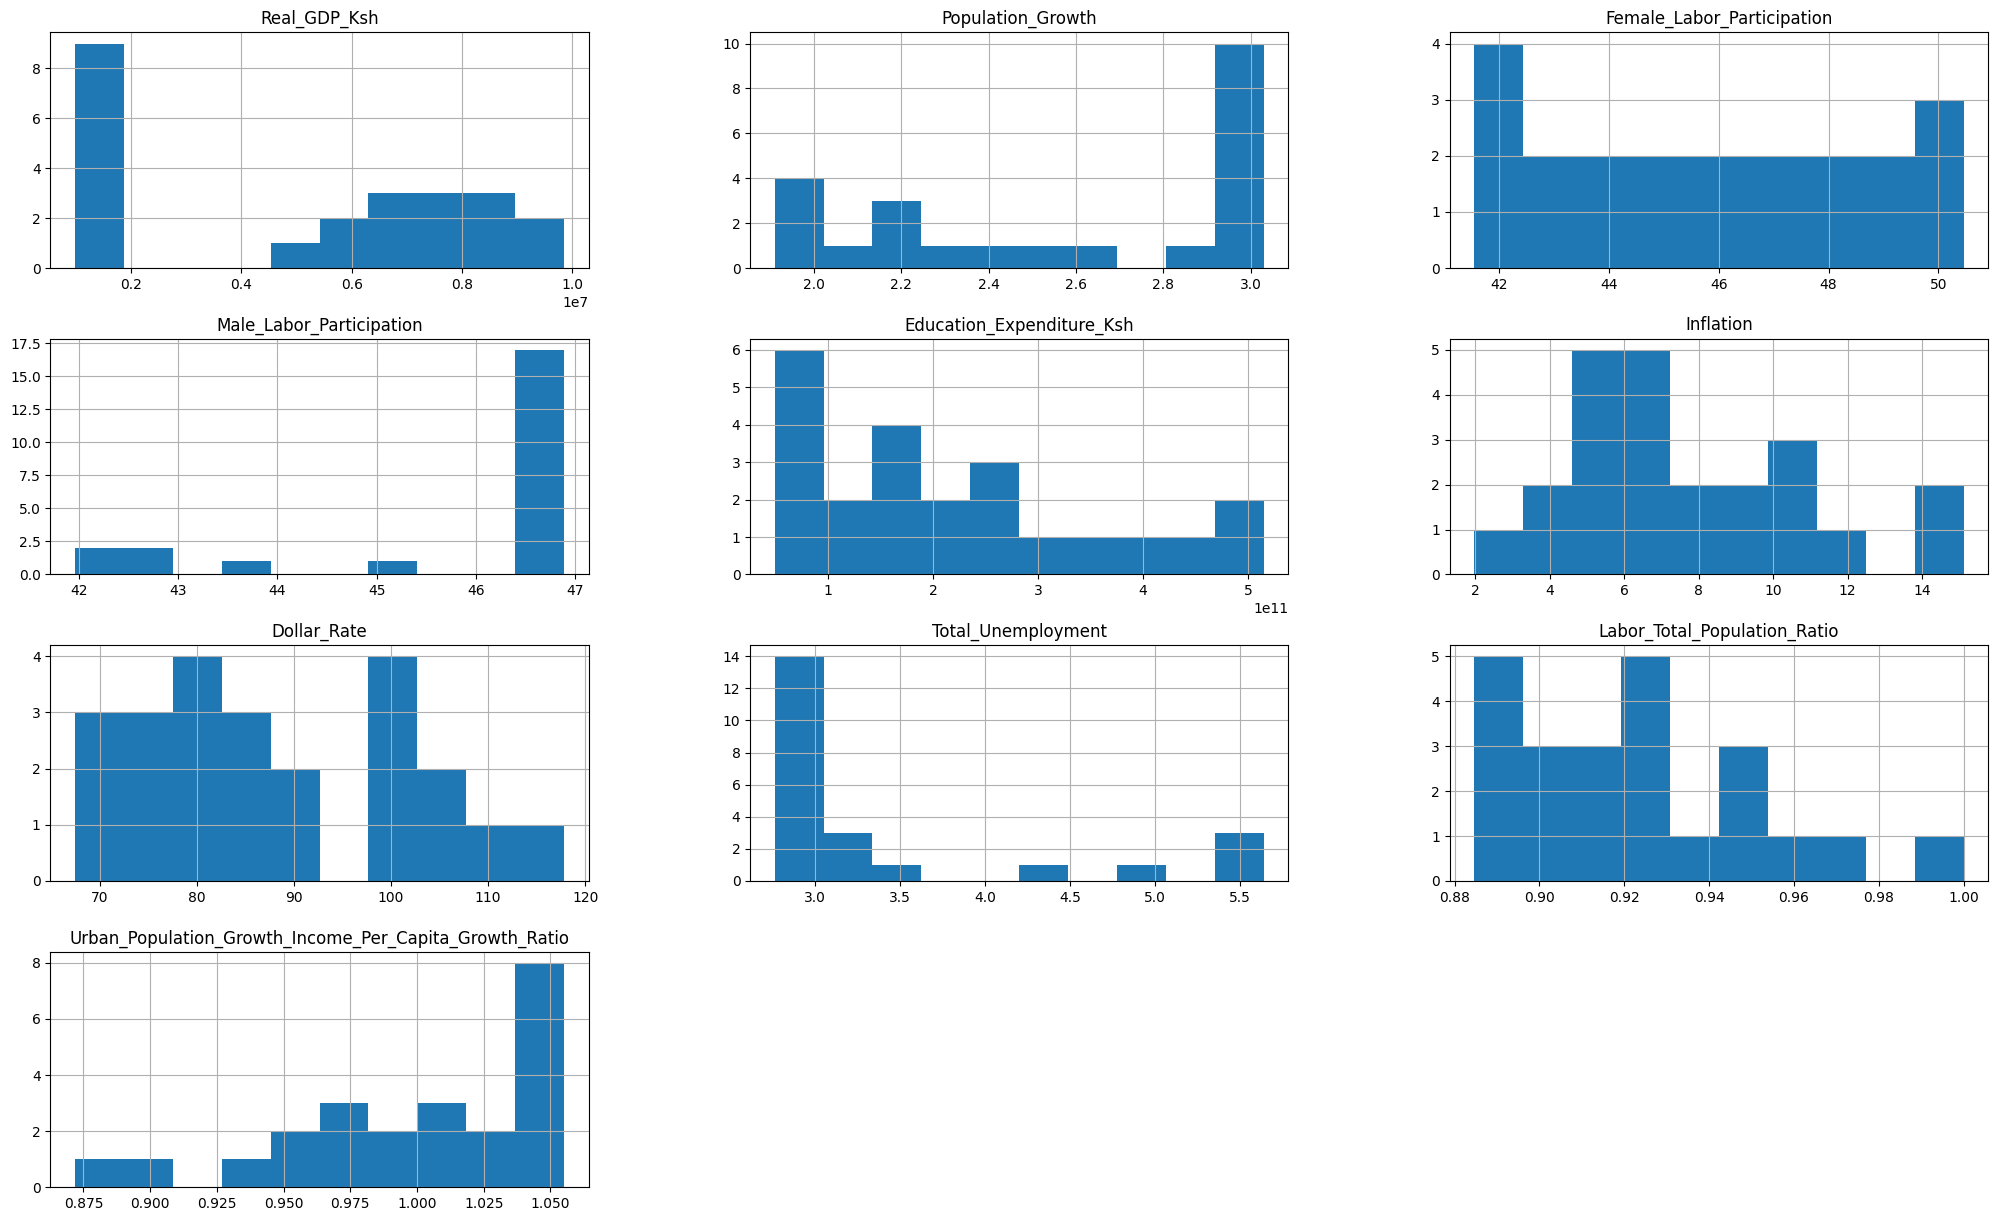

In [146]:
unemployment_df.hist(figsize=(25,15))

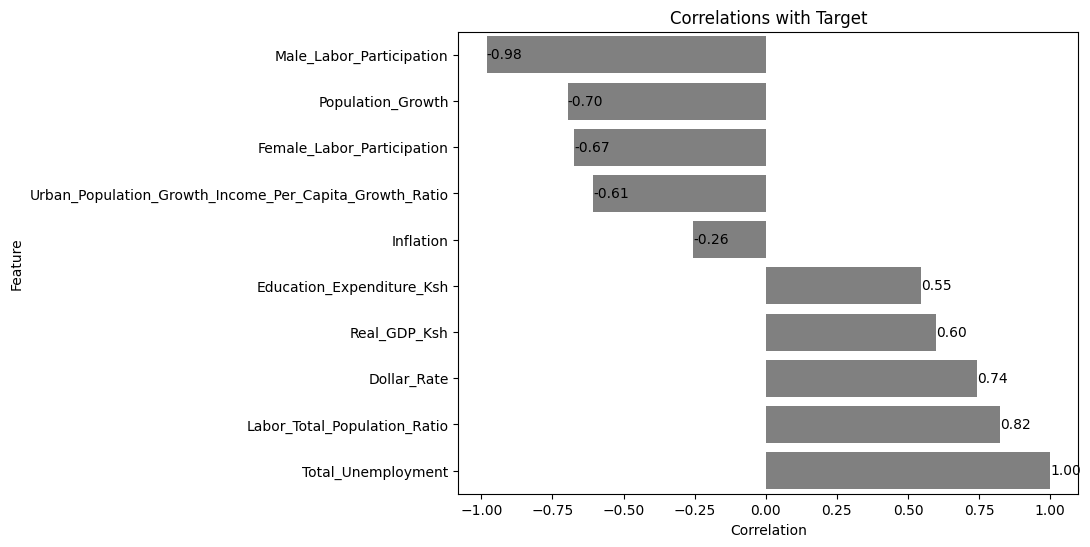

In [147]:
# Calculate the correlations between features and the target
correlations = unemployment_df.corr()['Total_Unemployment'].sort_values(ascending=True)

# Create a barplot to visualize correlations
plt.figure(figsize=(8, 6))
sns.barplot(x=correlations, y=correlations.index, orient='h',color="grey")
plt.title('Correlations with Target')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.grid(axis='x')

# Annotate the correlation values on the bars
for i, corr in enumerate(correlations):
    plt.text(corr, i, f'{corr:.2f}', va='center', fontsize=10, color='black')
plt.grid(axis='x')




## Scale the data to calculate the correlations

In [148]:
scaling=MinMaxScaler()
scaled=scaling.fit_transform(unemployment_df)
scaled_df= pd.DataFrame(scaled, columns=unemployment_df.columns)
scaled_df.index=unemployment_df.index

scaled_df.head()

,Real_GDP_Ksh,Population_Growth,Female_Labor_Participation,Male_Labor_Participation,Education_Expenditure_Ksh,Inflation,Dollar_Rate,Total_Unemployment,Labor_Total_Population_Ratio,Urban_Population_Growth_Income_Per_Capita_Growth_Ratio
Year,,,,,,,,,,
2000,0.000000,0.901786,1.000000,1.000000,0.000000,0.609589,0.172870,0.128472,0.308627,0.864619
2001,0.004201,1.000000,0.951794,0.995943,0.005148,0.286149,0.220265,0.107639,0.348408,0.976607
2002,0.004818,1.000000,0.904709,0.989858,0.022222,0.000000,0.223956,0.114583,0.338738,1.000000
2003,0.008209,0.946429,0.856502,0.985801,0.056633,0.596651,0.331130,0.097222,0.319463,0.913363
2004,0.014262,0.964286,0.809417,0.979716,0.069610,0.748097,0.261691,0.083333,0.297791,0.935571


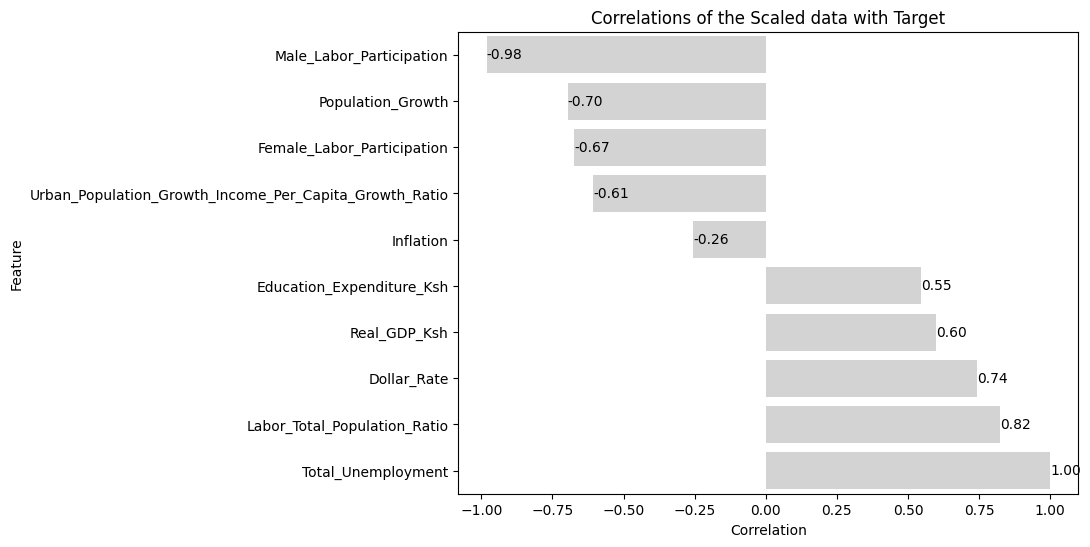

In [149]:

# Calculate the correlations between features and the target
correlations_new = scaled_df.corr()['Total_Unemployment'].sort_values(ascending=True)

# Create a barplot to visualize correlations
plt.figure(figsize=(8, 6))
sns.barplot(x=correlations_new, y=correlations_new.index, orient='h',color="lightgrey")
plt.title('Correlations of the Scaled data with Target')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.grid(axis='x')

# Annotate the correlation values on the bars
for i, corr in enumerate(correlations_new):
    plt.text(corr, i, f'{corr:.2f}', va='center', fontsize=10, color='black')
plt.grid(axis='x')



###  Comparing (above) the correations of the scaled data to the correlations of the original data, we realize that they are exactly the same. This validates our scaling method!

# Calculate ratio of each field with another to compare against the unemployment rate with a condition given that the correlation with the unemployment rate is > 0.5

In [150]:
# Get columns without the last
cols_without_last = scaled_df.drop(['Total_Unemployment'],axis=1).columns

# Create unique pairs without the last column
unique_pairs = list(combinations(cols_without_last, 2))

# Calculate ratios and check correlation with the last column
ratios = pd.DataFrame()
for col1, col2 in unique_pairs:
    ratio_name = f'{col1}_{col2}_Ratio'
    ratio = scaled_df[col1] / scaled_df[col2]

    correlation_with_last = ratio.corr(unemployment_df['Total_Unemployment'])

    if (correlation_with_last > 0.5) or (correlation_with_last < -0.5):
        ratios[ratio_name] = ratio



ratios = ratios[sorted(ratios.columns)]
#remove nan values by filling up with median
ratios.fillna(ratios.median(),inplace=True)
ratios.head()

,Dollar_Rate_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio,Education_Expenditure_Ksh_Inflation_Ratio,Female_Labor_Participation_Inflation_Ratio,Female_Labor_Participation_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio,Labor_Total_Population_Ratio_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio,Male_Labor_Participation_Inflation_Ratio,Male_Labor_Participation_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio,Population_Growth_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio,Real_GDP_Ksh_Female_Labor_Participation_Ratio,Real_GDP_Ksh_Inflation_Ratio,Real_GDP_Ksh_Male_Labor_Participation_Ratio,Real_GDP_Ksh_Population_Growth_Ratio,Real_GDP_Ksh_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio
Year,,,,,,,,,,,,,
2000,0.199938,0.000000,1.640449,1.156579,0.356952,1.640449,1.156579,1.042986,0.000000,0.000000,0.000000,0.000000,0.000000
2001,0.225541,0.017989,3.326215,0.974592,0.356754,3.480504,1.019799,1.023953,0.004414,0.014681,0.004218,0.004201,0.004302
2002,0.223956,0.996956,0.840822,0.904709,0.338738,1.646336,0.989858,1.000000,0.005325,1.387881,0.004867,0.004818,0.004818
2003,0.362540,0.094919,1.435515,0.937746,0.349766,1.652223,1.079310,1.036202,0.009585,0.013759,0.008327,0.008674,0.008988
2004,0.279712,0.093049,1.081967,0.865158,0.318299,1.309610,1.047185,1.030692,0.017620,0.019064,0.014557,0.014790,0.015244


In [151]:
scaled_df.head()

,Real_GDP_Ksh,Population_Growth,Female_Labor_Participation,Male_Labor_Participation,Education_Expenditure_Ksh,Inflation,Dollar_Rate,Total_Unemployment,Labor_Total_Population_Ratio,Urban_Population_Growth_Income_Per_Capita_Growth_Ratio
Year,,,,,,,,,,
2000,0.000000,0.901786,1.000000,1.000000,0.000000,0.609589,0.172870,0.128472,0.308627,0.864619
2001,0.004201,1.000000,0.951794,0.995943,0.005148,0.286149,0.220265,0.107639,0.348408,0.976607
2002,0.004818,1.000000,0.904709,0.989858,0.022222,0.000000,0.223956,0.114583,0.338738,1.000000
2003,0.008209,0.946429,0.856502,0.985801,0.056633,0.596651,0.331130,0.097222,0.319463,0.913363
2004,0.014262,0.964286,0.809417,0.979716,0.069610,0.748097,0.261691,0.083333,0.297791,0.935571


In [152]:
scaled_df

,Real_GDP_Ksh,Population_Growth,Female_Labor_Participation,Male_Labor_Participation,Education_Expenditure_Ksh,Inflation,Dollar_Rate,Total_Unemployment,Labor_Total_Population_Ratio,Urban_Population_Growth_Income_Per_Capita_Growth_Ratio
Year,,,,,,,,,,
2000,0.000000,0.901786,1.000000,1.000000,0.000000,0.609589,0.172870,0.128472,0.308627,0.864619
2001,0.004201,1.000000,0.951794,0.995943,0.005148,0.286149,0.220265,0.107639,0.348408,0.976607
2002,0.004818,1.000000,0.904709,0.989858,0.022222,0.000000,0.223956,0.114583,0.338738,1.000000
2003,0.008209,0.946429,0.856502,0.985801,0.056633,0.596651,0.331130,0.097222,0.319463,0.913363
2004,0.014262,0.964286,0.809417,0.979716,0.069610,0.748097,0.261691,0.083333,0.297791,0.935571
2005,0.021416,0.955357,0.762332,0.975659,0.091696,0.604262,0.160777,0.072917,0.251643,0.921914
2006,0.030063,0.946429,0.714126,0.971602,0.159338,0.308980,0.092873,0.062500,0.188303,0.922375
2007,0.039916,0.946429,0.665919,0.965517,0.180148,0.175038,0.000000,0.055556,0.114773,0.917403
2008,0.042218,0.955357,0.617713,0.963489,0.200466,1.000000,0.030496,0.076389,0.049349,0.932878


In [153]:
ratios["IncomePerCapita_TotalPop_Growth_Ratio"]=scaled_df["Urban_Population_Growth_Income_Per_Capita_Growth_Ratio"]/scaled_df["Population_Growth"]


In [154]:
#ratios.fillna(ratios.median(),inplace=True)
ratios["Total_Unemployment"]=unemployment_df["Total_Unemployment"]
ratios.corr()["Total_Unemployment"]

Dollar_Rate_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio                     0.431668
Education_Expenditure_Ksh_Inflation_Ratio                                                    0.568042
Female_Labor_Participation_Inflation_Ratio                                                  -0.510485
Female_Labor_Participation_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio     -0.626034
Labor_Total_Population_Ratio_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio    0.576646
Male_Labor_Participation_Inflation_Ratio                                                    -0.592210
Male_Labor_Participation_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio       -0.469936
Population_Growth_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio              -0.593588
Real_GDP_Ksh_Female_Labor_Participation_Ratio                                                0.630824
Real_GDP_Ksh_Inflation_Ratio                                                      

# Correlations for all the ratios

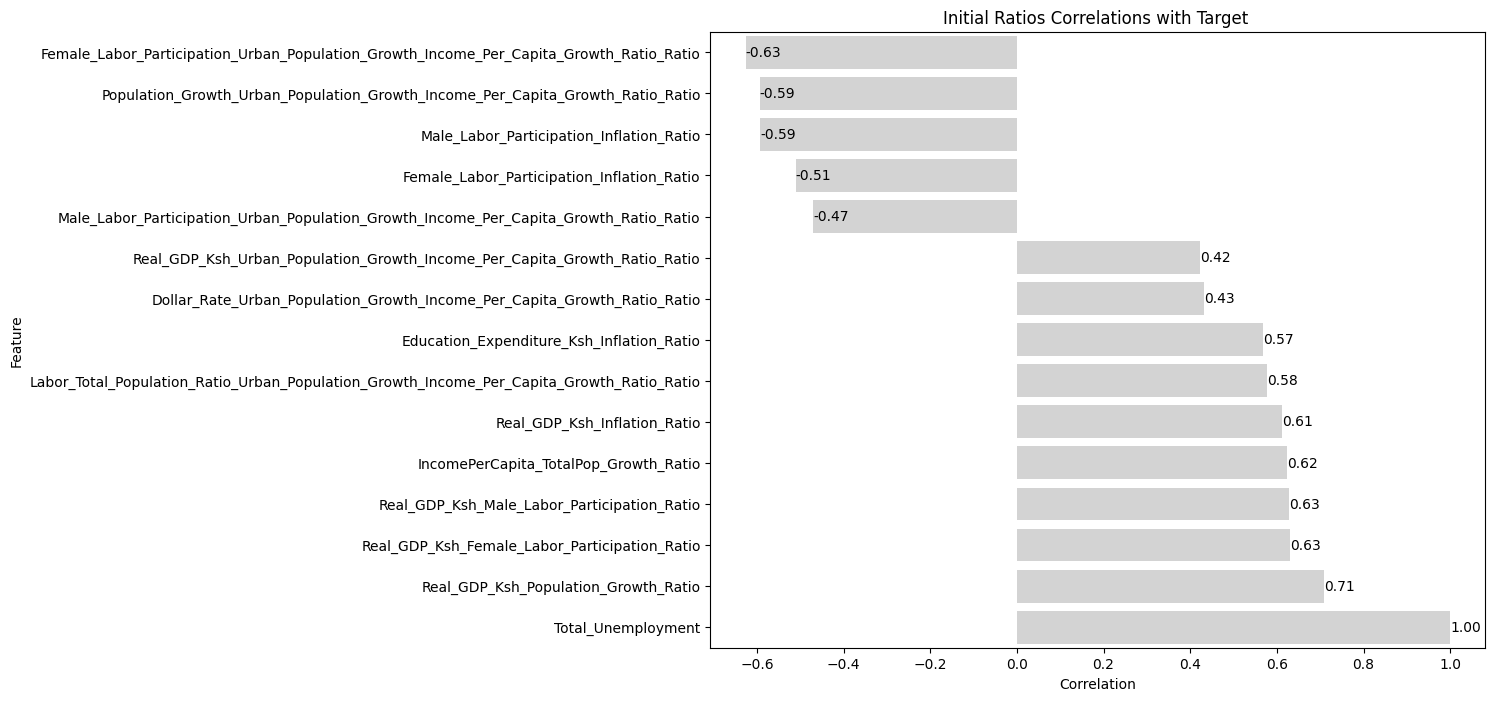

In [155]:

# Calculate the correlations between features and the target
correlations_ratios = ratios.corr()['Total_Unemployment'].sort_values(ascending=True)

# Create a barplot to visualize correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=correlations_ratios, y=correlations_ratios.index, orient='h',color="lightgrey")
plt.title('Initial Ratios Correlations with Target ')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.grid(axis='x')

# Annotate the correlation values on the bars
for i, corr in enumerate(correlations_ratios):
    plt.text(corr, i, f'{corr:.2f}', va='center', fontsize=10, color='black')
plt.grid(axis='x')

In [156]:
ratios

,Dollar_Rate_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio,Education_Expenditure_Ksh_Inflation_Ratio,Female_Labor_Participation_Inflation_Ratio,Female_Labor_Participation_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio,Labor_Total_Population_Ratio_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio,Male_Labor_Participation_Inflation_Ratio,Male_Labor_Participation_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio,Population_Growth_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio,Real_GDP_Ksh_Female_Labor_Participation_Ratio,Real_GDP_Ksh_Inflation_Ratio,Real_GDP_Ksh_Male_Labor_Participation_Ratio,Real_GDP_Ksh_Population_Growth_Ratio,Real_GDP_Ksh_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio,IncomePerCapita_TotalPop_Growth_Ratio,Total_Unemployment
Year,,,,,,,,,,,,,,,
2000,0.199938,0.000000,1.640449,1.156579,0.356952,1.640449,1.156579,1.042986,0.000000,0.000000,0.000000,0.000000,0.000000,0.958786,3.13
2001,0.225541,0.017989,3.326215,0.974592,0.356754,3.480504,1.019799,1.023953,0.004414,0.014681,0.004218,0.004201,0.004302,0.976607,3.07
2002,0.223956,0.996956,0.840822,0.904709,0.338738,1.646336,0.989858,1.000000,0.005325,1.387881,0.004867,0.004818,0.004818,1.000000,3.09
2003,0.362540,0.094919,1.435515,0.937746,0.349766,1.652223,1.079310,1.036202,0.009585,0.013759,0.008327,0.008674,0.008988,0.965062,3.04
2004,0.279712,0.093049,1.081967,0.865158,0.318299,1.309610,1.047185,1.030692,0.017620,0.019064,0.014557,0.014790,0.015244,0.970222,3.00
2005,0.174395,0.151749,1.261592,0.826901,0.272957,1.614630,1.058297,1.036275,0.028093,0.035442,0.021950,0.022417,0.023230,0.964995,2.97
2006,0.100689,0.515691,2.311234,0.774225,0.204150,3.144546,1.053370,1.026078,0.042098,0.097298,0.030942,0.031765,0.032593,0.974585,2.94
2007,0.000000,1.029195,3.804426,0.725874,0.125106,5.516042,1.052446,1.031639,0.059941,0.228042,0.041342,0.042175,0.043510,0.969332,2.92
2008,0.032690,0.200466,0.617713,0.662158,0.052900,0.963489,1.032813,1.024096,0.068345,0.042218,0.043818,0.044191,0.045255,0.976471,2.98


In [157]:
ratios_final=ratios[["Total_Unemployment","Labor_Total_Population_Ratio_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio","IncomePerCapita_TotalPop_Growth_Ratio"]]


KeyError: "['Urban_Population_Growth_Income_Per_Capita_Growth_Ratio'] not in index" pliz check this


### From the above correlation plot, we will remove all the factors which try to divide percentages by the actual numbers, because they would not reveal a meaninful correlation even if mathematically it is a high number. Moreover, if an original feature shows a stronger correlation or anti-correlation as compared to either of these ratios, we kept the original feature instead. Using this intuition, we decide to only consider "Labor_Total_Population_Ratio" and "Urban_Population_Growth_Income_Per_Capita_Growth_Ratio" from above.

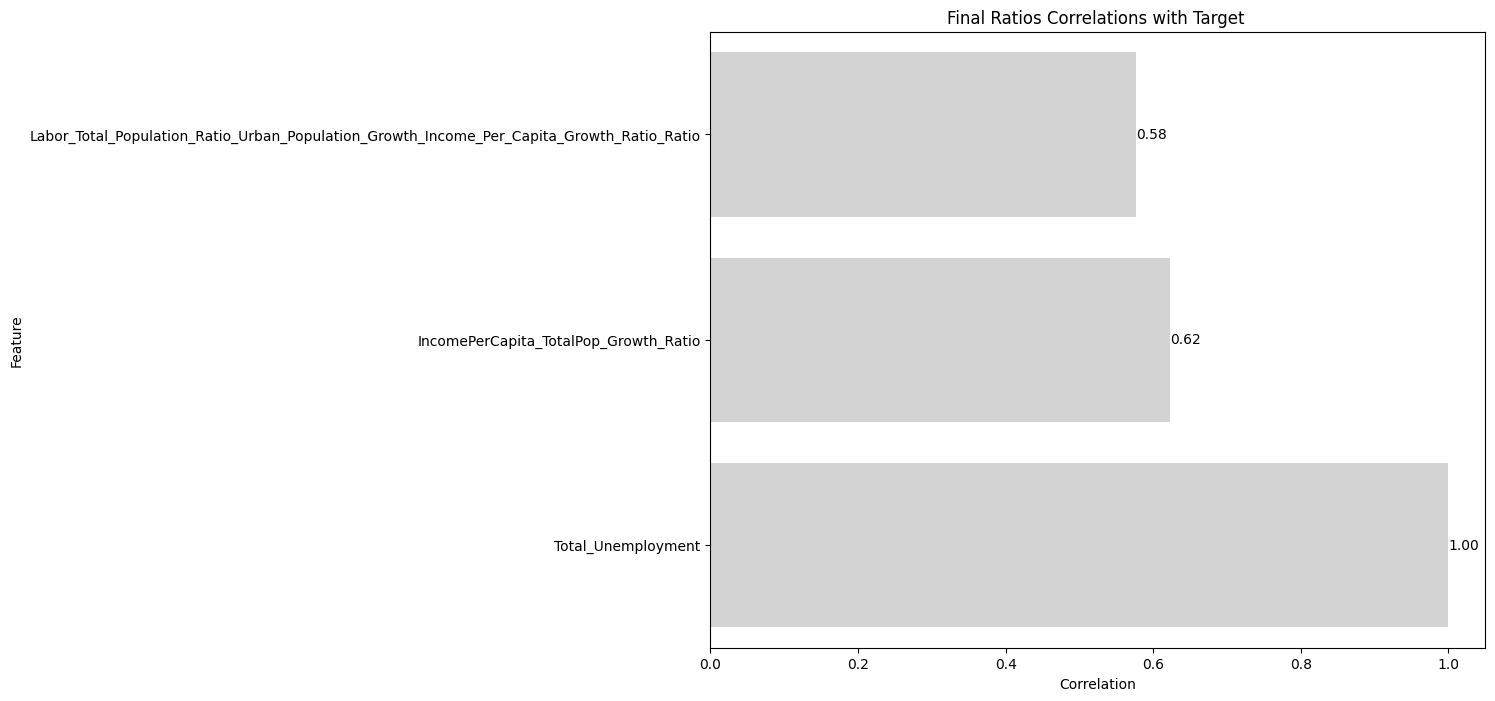

In [158]:
#ratios.drop("Urban_Population_Growth_Income_Per_Capita_Growth_Ratio",axis=1,inplace=True)
ratios_final.head()
# Calculate the correlations between features and the target
correlations_ratios = ratios_final.corr()['Total_Unemployment'].sort_values(ascending=True)

# Create a barplot to visualize correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=correlations_ratios, y=correlations_ratios.index, orient='h',color="lightgrey")
plt.title('Final Ratios Correlations with Target ')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.grid(axis='x')

# Annotate the correlation values on the bars
for i, corr in enumerate(correlations_ratios):
    plt.text(corr, i, f'{corr:.2f}', va='center', fontsize=10, color='black')
plt.grid(axis='x')

# Create the final data set based on the following findings:
- Male and female labor force participation are strongly anticorrelated
-  Labor to total population ratio is better than these two factors alone
- Plus all the original features in

In [159]:
unemployment_final=unemployment_df[['Real_GDP_Ksh','Population_Growth','Female_Labor_Participation','Male_Labor_Participation','Education_Expenditure_Ksh','Inflation','Dollar_Rate']]
scaled_final=scaled_df[['Real_GDP_Ksh','Population_Growth','Female_Labor_Participation','Male_Labor_Participation','Education_Expenditure_Ksh','Total_Unemployment']]

## Create the final dataset:
- with the original data and ratios

In [160]:
#ratios_scaled_final=pd.concat([scaled_final,ratios_final],axis=1)
ratios_original_final=pd.concat([unemployment_final,ratios_final],axis=1)
#ratios_scaled_final.to_csv("Scaled_data_and_Ratios.csv")
ratios_original_final.to_csv("Feature_Engineered_Dataset.csv")



In [161]:
ratios_original_final.head()
ratios_original_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 2000 to 2022
Data columns (total 10 columns):
 #   Column                                                                                     Non-Null Count  Dtype  
---  ------                                                                                     --------------  -----  
 0   Real_GDP_Ksh                                                                               23 non-null     int64  
 1   Population_Growth                                                                          23 non-null     float64
 2   Female_Labor_Participation                                                                 23 non-null     float64
 3   Male_Labor_Participation                                                                   23 non-null     float64
 4   Education_Expenditure_Ksh                                                                  23 non-null     float64
 5   Inflation                                           

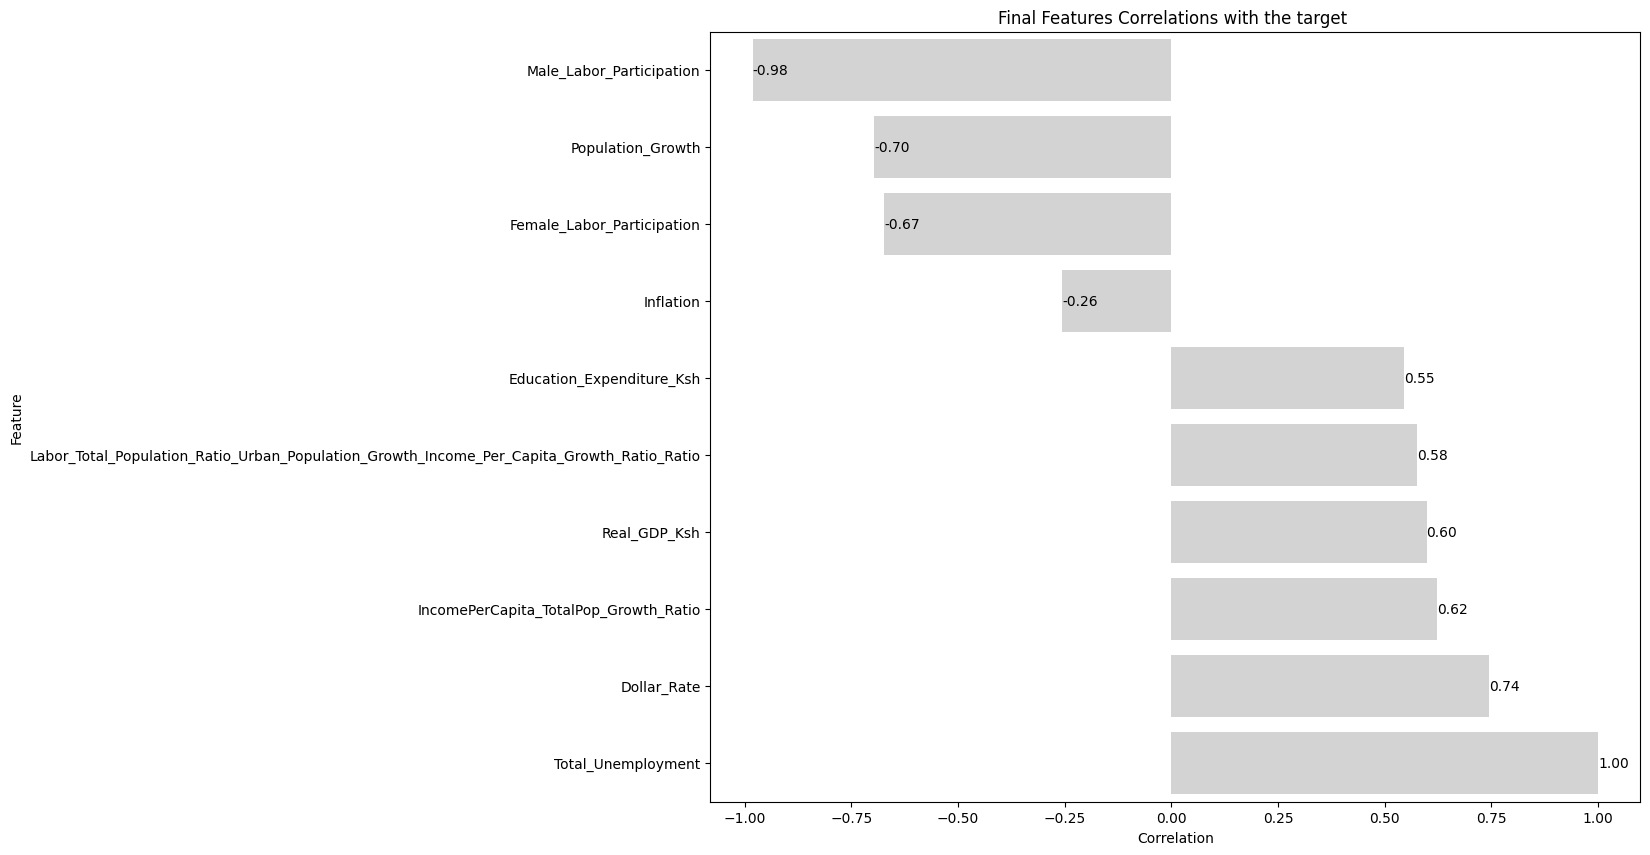

In [162]:
# Calculate the correlations between features and the target
correlations_scaled = ratios_original_final.corr()['Total_Unemployment'].sort_values(ascending=True)

# Create a barplot to visualize correlations
plt.figure(figsize=(12, 10))
sns.barplot(x=correlations_scaled, y=correlations_scaled.index, orient='h',color="lightgrey")
plt.title('Final Features Correlations with the target ')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.grid(axis='x')

# Annotate the correlation values on the bars
for i, corr in enumerate(correlations_scaled):
    plt.text(corr, i, f'{corr:.2f}', va='center', fontsize=10, color='black')
plt.grid(axis='x')

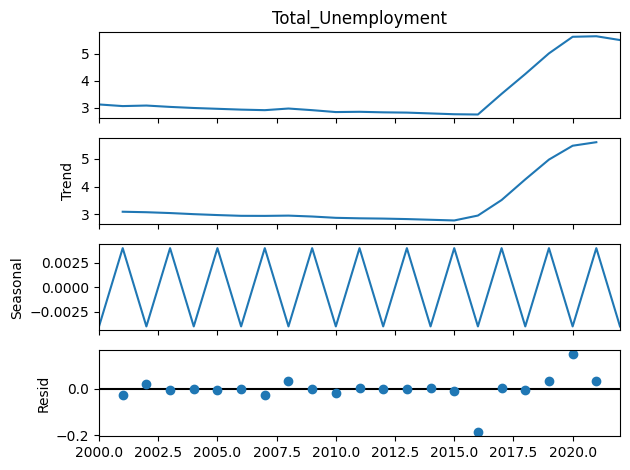

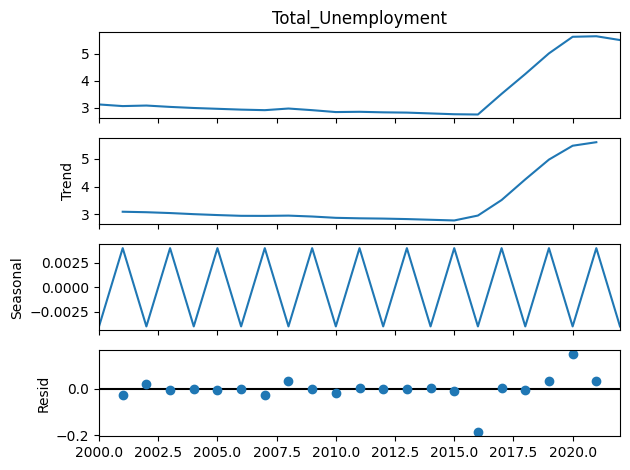

In [163]:
##Seasonality (bonus)
series = pd.Series(unemployment_df['Total_Unemployment'])
results = seasonal_decompose(series, model='additive',period=2)
results.plot()

In [164]:
# Calculate the correlations between features and the target
correlations = unemployment_df.corr()['Total_Unemployment'].sort_values(ascending=True)
correlations

Male_Labor_Participation                                 -0.981433
Population_Growth                                        -0.695958
Female_Labor_Participation                               -0.673330
Urban_Population_Growth_Income_Per_Capita_Growth_Ratio   -0.607461
Inflation                                                -0.256000
Education_Expenditure_Ksh                                 0.545905
Real_GDP_Ksh                                              0.597949
Dollar_Rate                                               0.743674
Labor_Total_Population_Ratio                              0.823253
Total_Unemployment                                        1.000000
Name: Total_Unemployment, dtype: float64

**MODEL BUILDING**

In [165]:

# Define the relevant features with a correlation of 0.5 or higher
selected_features = [
    'Male_Labor_Participation',
    'Population_Growth',
    'Female_Labor_Participation',
    'Urban_Population_Growth_Income_Per_Capita_Growth_Ratio',
    'Education_Expenditure_Ksh',
    'Real_GDP_Ksh',
    'Dollar_Rate',
    'Labor_Total_Population_Ratio'
]

# Define X and y
X = unemployment_df[selected_features]
y = unemployment_df['Total_Unemployment']

# Split the dataset into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [166]:


# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on your training data and transform the features
X_train= scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test = scaler.transform(X_test)

ARIMA
RMSE: 2.038675662250477
MAE: 1.9459922577982565
R2: -13.859274289436053


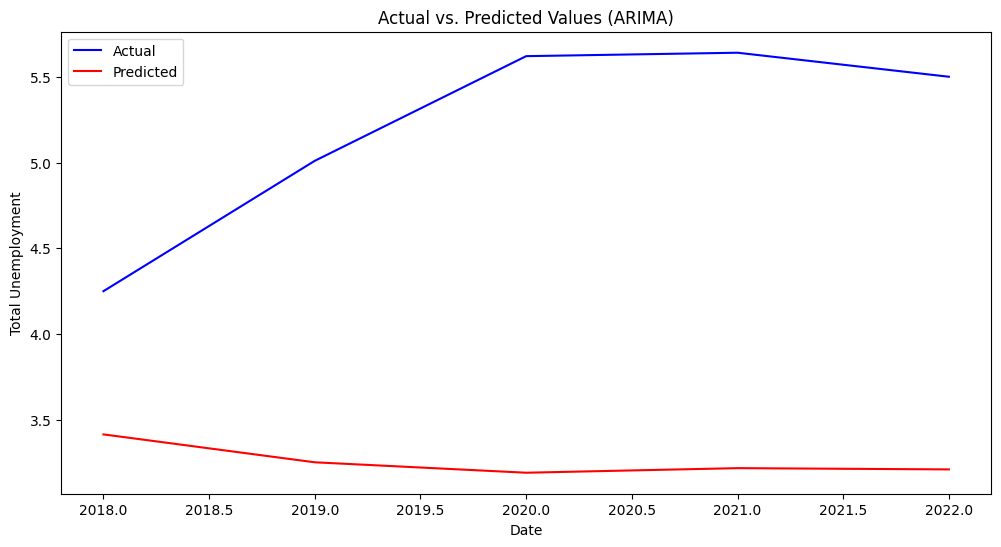

In [167]:


# Define the training and testing split
train_size = int(0.8 * len(unemployment_df))
train, test = unemployment_df[:train_size], unemployment_df[train_size:]

# Select the target column for forecasting
target_column = 'Total_Unemployment'

# Build and train the ARIMA model
model = ARIMA(train[target_column], order=(5, 1, 0))
model_fit = model.fit()
predictions = model_fit.forecast(steps=len(test))

# Evaluate the ARIMA model
rmse = np.sqrt(mean_squared_error(test[target_column], predictions))
mae = mean_absolute_error(test[target_column], predictions)
r2 = r2_score(test[target_column], predictions)

print('ARIMA')
print('RMSE:', rmse)
print('MAE:', mae)
print('R2:', r2)

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test[target_column], label='Actual', color='blue')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.title('Actual vs. Predicted Values (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Total Unemployment')
plt.legend()
plt.show()


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11395D-01    |proj g|=  2.56076D-01

At iterate    5    f=  1.03981D-01    |proj g|=  1.53075D-02

At iterate   10    f=  1.03616D-01    |proj g|=  4.67685D-03

At iterate   15    f=  1.03597D-01    |proj g|=  7.00620D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     18     23      1     0     0   3.836D-05   1.036D-01
  F =  0.10359703144635962     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA
R

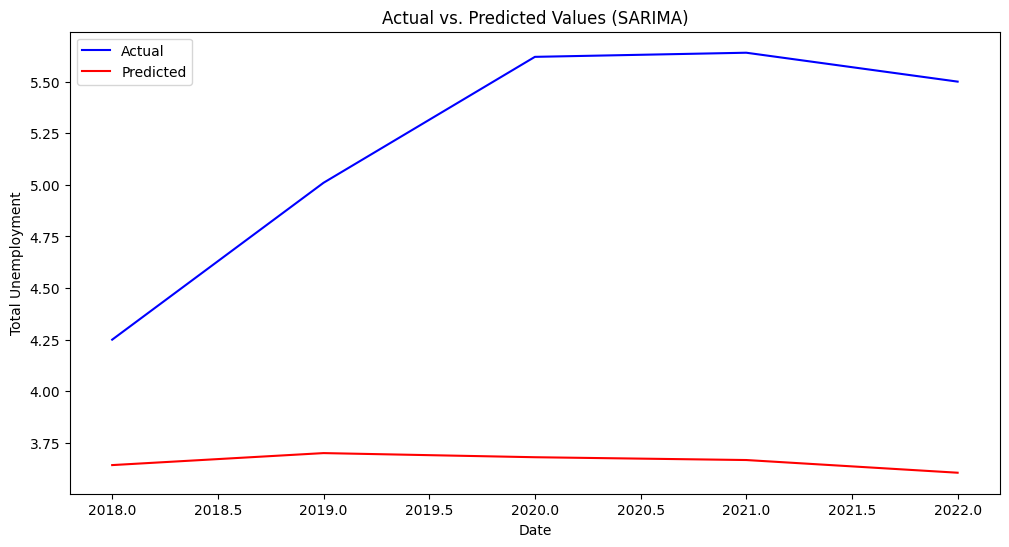

In [168]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Build and train the SARIMA model
model = SARIMAX(train[target_column], order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))

# Evaluate the SARIMA model
rmse = np.sqrt(mean_squared_error(test[target_column], predictions))
mae = mean_absolute_error(test[target_column], predictions)
r2 = r2_score(test[target_column], predictions)

print('SARIMA')
print('RMSE:', rmse)
print('MAE:', mae)
print('R2:', r2)

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test[target_column], label='Actual', color='blue')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.title('Actual vs. Predicted Values (SARIMA)')
plt.xlabel('Date')
plt.ylabel('Total Unemployment')
plt.legend()
plt.show()


In [169]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize the Elastic Net regressor
elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5)  # You can adjust the alpha and l1_ratio values

# Fit the model to the training data
elastic_net.fit(X_train, y_train)

# Make predictions on the test data
elastic_net_pred = elastic_net.predict(X_test)

# Evaluate the model
print('Elastic Net Regression')
print('RMSE:', np.sqrt(mean_squared_error(y_test, elastic_net_pred)))
print('MAE:', mean_absolute_error(y_test, elastic_net_pred))
print('R2:', r2_score(y_test, elastic_net_pred))


Elastic Net Regression
RMSE: 0.355409736414102
MAE: 0.309445310310398
R2: -0.9342778503298643


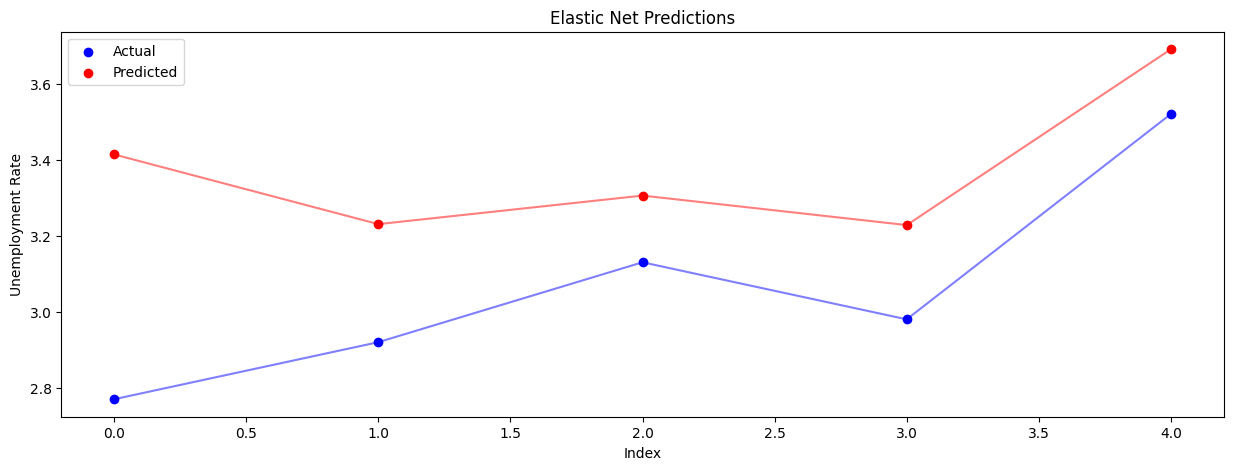

In [170]:

# Visualizing the predictions
plt.figure(figsize=(15, 5))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(elastic_net_pred)), elastic_net_pred, color='red', label='Predicted')
plt.plot(y_test.values, color='blue', alpha=0.5)
plt.plot(elastic_net_pred, color='red', alpha=0.5)
plt.title('Elastic Net Predictions')
plt.xlabel('Index')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.show()


**Linear Regression**

In [171]:
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = model.predict(X_test)

# Evaluate the model
print('Linear Regression')
print('RMSE: ', np.sqrt(mean_squared_error(y_test, predictions)))
print('MAE: ', mean_absolute_error(y_test, predictions))
print('R2: ', r2_score(y_test, predictions))

Linear Regression
RMSE:  0.23632588809326804
MAE:  0.2012428863488666
R2:  0.144770222603947


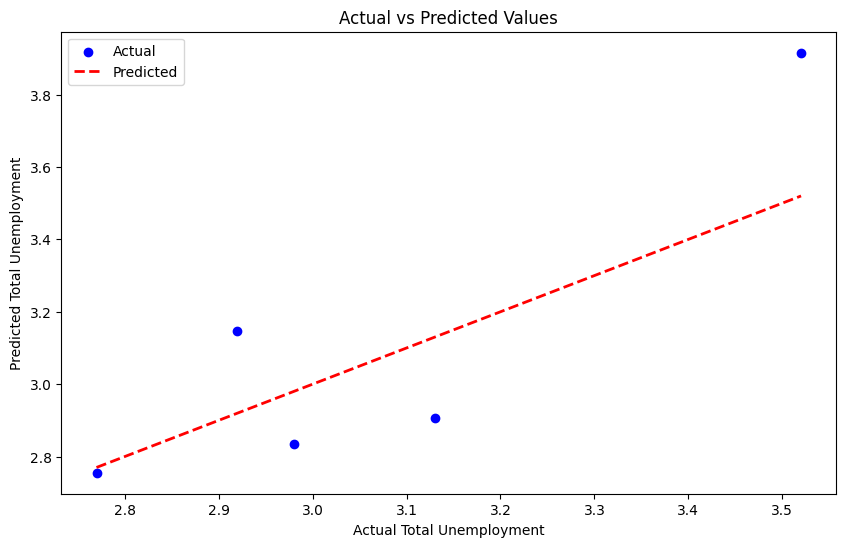

In [172]:


# Visualize the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, color='blue', label='Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Total Unemployment')
plt.ylabel('Predicted Total Unemployment')
plt.legend()
plt.show()


**XGBRegressor**

In [173]:
# Initialize the XGBoost regressor with the specified parameters
xgb = XGBRegressor(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=3,
    n_estimators=200,
    subsample=0.8
)

# Fit the XGBoost model to the training data
xgb.fit(X_train, y_train)

# Make predictions on the test data
xgb_pred = xgb.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate the XGBoost model
rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
mae = mean_absolute_error(y_test, xgb_pred)
r2 = r2_score(y_test, xgb_pred)

print('XGBoost Evaluation Metrics:')
print('RMSE:', rmse)
print('MAE:', mae)
print('R2:', r2)


XGBoost Evaluation Metrics:
RMSE: 0.2983921649846769
MAE: 0.20397148704528806
R2: -0.3634369123521166


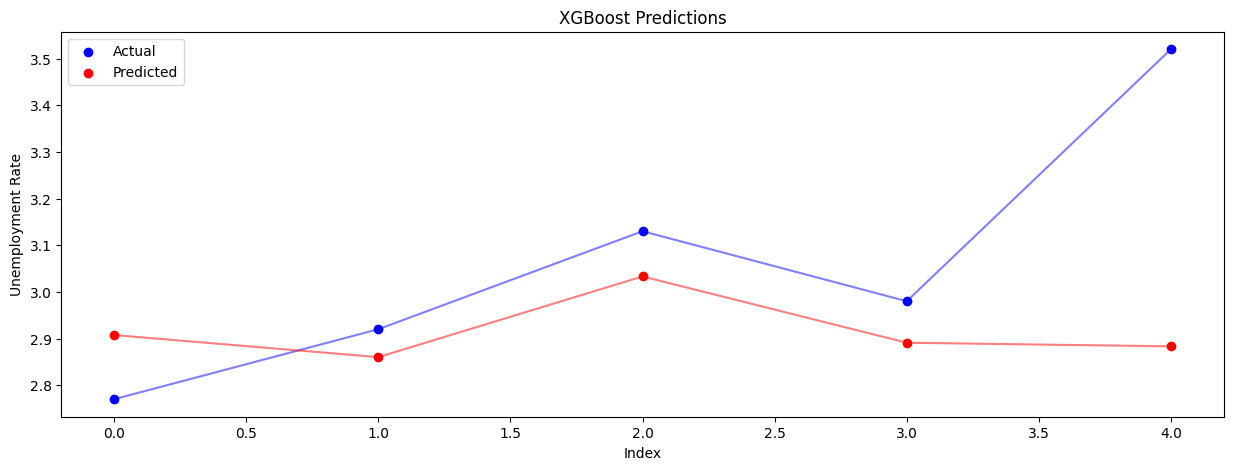

In [174]:

# Visualize the predictions
plt.figure(figsize=(15, 5))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(xgb_pred)), xgb_pred, color='red', label='Predicted')
plt.plot(y_test.values, color='blue', alpha=0.5)
plt.plot(xgb_pred, color='red', alpha=0.5)
plt.title('XGBoost Predictions')
plt.xlabel('Index')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.show()


**LIGHTGBM**

In [175]:

import lightgbm as lgb
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=100,
    max_depth=-1,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0
)

# Fit the model 
lgbm.fit(X_train, y_train)

# Making predictions 
lgbm_pred = lgbm.predict(X_test)

# Evaluate the model
print('LightGBM')
print('RMSE:', np.sqrt(mean_squared_error(y_test, lgbm_pred)))
print('MAE:', mean_absolute_error(y_test, lgbm_pred))
print('R2:', r2_score(y_test, lgbm_pred))


LightGBM
RMSE: 0.5535205276285308
MAE: 0.4909999740388661
R2: -3.6916724014787317


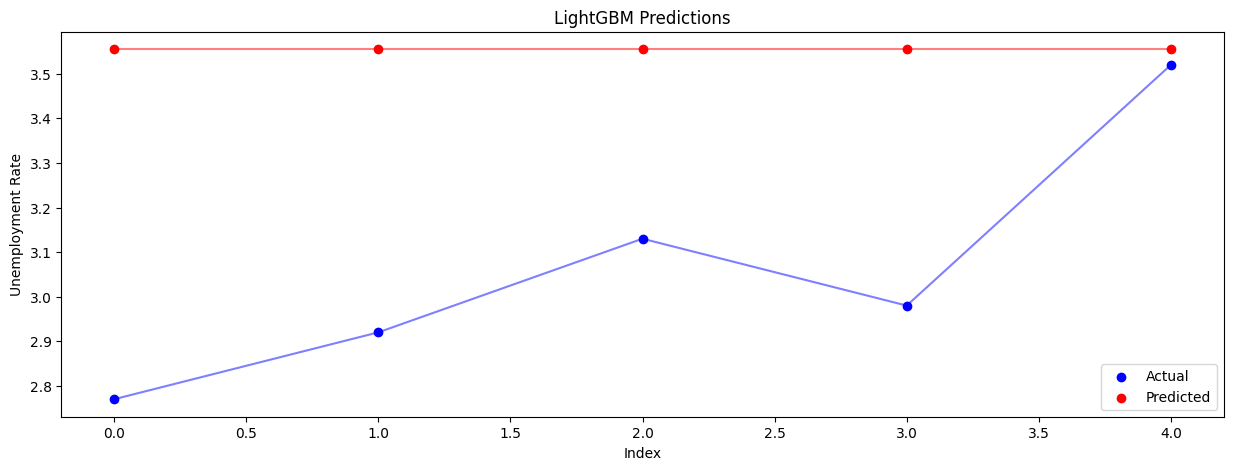

In [176]:
# Visualizing the predictions
plt.figure(figsize=(15, 5))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(lgbm_pred)), lgbm_pred, color='red', label='Predicted')
plt.plot(y_test.values, color='blue', alpha=0.5)
plt.plot(lgbm_pred, color='red', alpha=0.5)
plt.title('LightGBM Predictions')
plt.xlabel('Index')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.show()


**RANDOM FOREST**

In [177]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)

# Fit the model 
rf.fit(X_train, y_train)

# Make predictions on the test data
rf_pred = rf.predict(X_test)

# Evaluating the model
print('Random Forest')
print('RMSE:', np.sqrt(mean_squared_error(y_test,rf_pred)))
print('MAE:', mean_absolute_error(y_test, rf_pred))
print('R2:', r2_score(y_test, rf_pred))



Random Forest
RMSE: 0.13909262381593007
MAE: 0.12261999999999987
R2: 0.7037431397770453


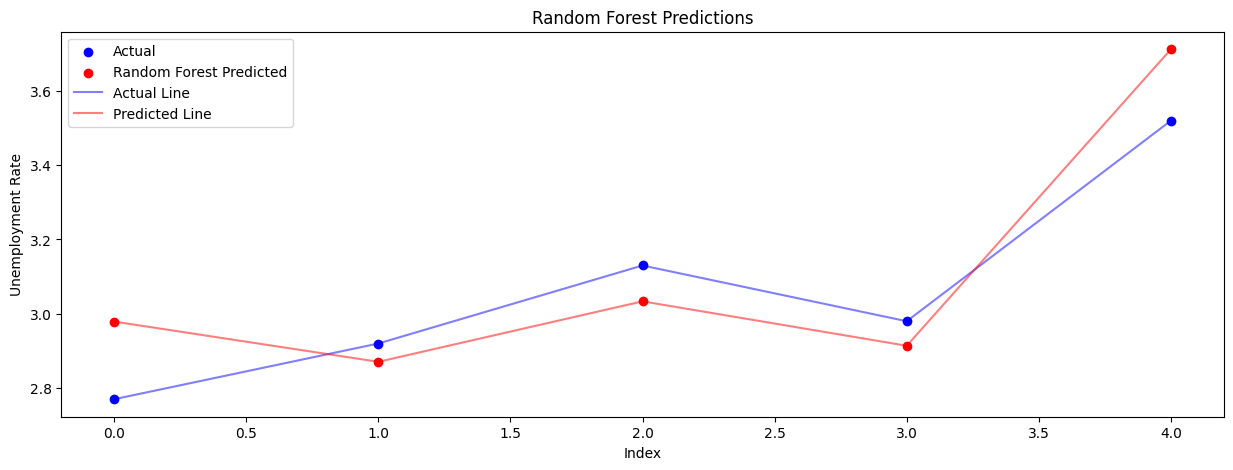

In [178]:
# Visualizing the Random Forest predictions 
plt.figure(figsize=(15, 5))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(rf_pred)), rf_pred, color='red', label='Random Forest Predicted')
plt.plot(y_test.values, color='blue', alpha=0.5, label='Actual Line')
plt.plot(rf_pred, color='red', alpha=0.5, label='Predicted Line')
plt.title('Random Forest Predictions')
plt.xlabel('Index')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.show()


**ADA BOOST**

In [179]:


# Initialize the AdaBoostRegressor
ada_boost = AdaBoostRegressor(learning_rate=0.2, loss='square', n_estimators=200, random_state=42)

# Fit the model to the training data
ada_boost.fit(X_train, y_train)

# Make predictions on the test data
ada_boost_pred = ada_boost.predict(X_test)

# Evaluate the AdaBoost model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, ada_boost_pred))
mae = mean_absolute_error(y_test, ada_boost_pred)
r2 = r2_score(y_test, ada_boost_pred)

print('AdaBoost Evaluation Metrics:')
print('RMSE:', rmse)
print('MAE:', mae)
print('R2:', r2)


AdaBoost Evaluation Metrics:
RMSE: 0.1997512341778032
MAE: 0.12833333333333324
R2: 0.38900288564933894


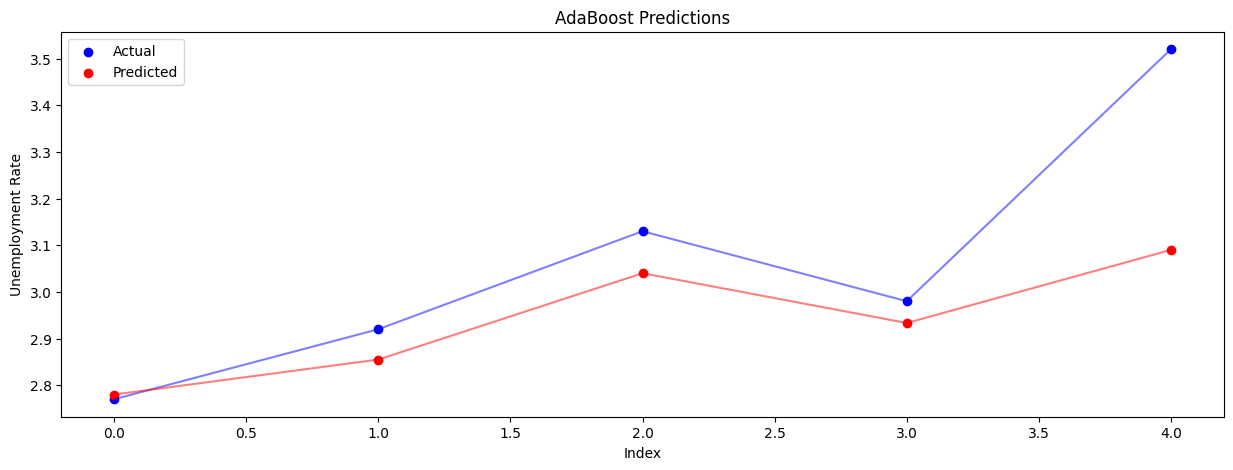

In [180]:
# Visualizing the predictions
plt.figure(figsize=(15, 5))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(ada_boost_pred)), ada_boost_pred, color='red', label='Predicted')
plt.plot(y_test.values, color='blue', alpha=0.5)
plt.plot(ada_boost_pred, color='red', alpha=0.5)
plt.title('AdaBoost Predictions')
plt.xlabel('Index')
plt.ylabel ('Unemployment Rate')
plt.legend()
plt.show()


**CAT Boost Regressor**

In [181]:


# Initialize the CatBoost regressor
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', random_seed=42)

# Fit the model to the training data
catboost_model.fit(X_train, y_train)

# Make predictions on the test data
catboost_pred = catboost_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print('CatBoost')
print('RMSE: ', np.sqrt(mean_squared_error(y_test, catboost_pred)))
print('MAE: ', mean_absolute_error(y_test, catboost_pred))
print('R2: ', r2_score(y_test, catboost_pred))



0:	learn: 1.0099029	total: 451us	remaining: 451ms
1:	learn: 0.9561703	total: 1.32ms	remaining: 659ms
2:	learn: 0.9152232	total: 1.7ms	remaining: 565ms
3:	learn: 0.8769842	total: 2.03ms	remaining: 505ms
4:	learn: 0.8345043	total: 2.29ms	remaining: 457ms
5:	learn: 0.7955654	total: 2.53ms	remaining: 419ms
6:	learn: 0.7487737	total: 2.68ms	remaining: 381ms
7:	learn: 0.7044233	total: 2.82ms	remaining: 350ms
8:	learn: 0.6722249	total: 3.06ms	remaining: 337ms
9:	learn: 0.6389888	total: 3.3ms	remaining: 327ms
10:	learn: 0.6074218	total: 3.54ms	remaining: 318ms
11:	learn: 0.5855878	total: 3.9ms	remaining: 321ms
12:	learn: 0.5650760	total: 4.23ms	remaining: 321ms
13:	learn: 0.5376227	total: 4.5ms	remaining: 317ms
14:	learn: 0.5135629	total: 4.87ms	remaining: 320ms
15:	learn: 0.4876286	total: 5.16ms	remaining: 317ms
16:	learn: 0.4693547	total: 5.5ms	remaining: 318ms
17:	learn: 0.4467312	total: 5.71ms	remaining: 311ms
18:	learn: 0.4241751	total: 6.03ms	remaining: 311ms
19:	learn: 0.4047245	total: 

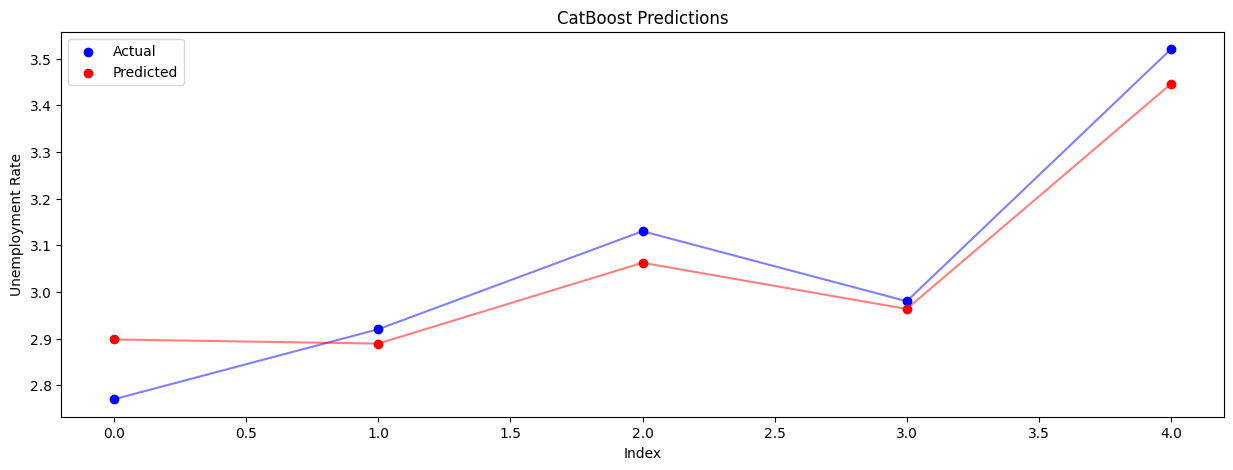

In [182]:
plt.figure(figsize=(15, 5))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(catboost_pred)), catboost_pred, color='red', label='Predicted')
plt.plot(y_test.values, color='blue', alpha=0.5)
plt.plot(catboost_pred, color='red', alpha=0.5)
plt.title('CatBoost Predictions')
plt.xlabel('Index')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.show()


## This is all Folks!!